# Mohammad Amin Nazerzadeh: mohammad.nazerzadeh@studio.unibo.it
# Davide Baldelli: davide.baldelli4@studio.unibo.it
# Mohammad Reza Ghasemi Madani: mohammadreza.ghasemi@studio.unibo.it 

# Retriever submodule on HotpotQA

In this notebook, we will train a small-bert model on a task of classifying a number of selected documents as being relevant to a question that is provided to the model. This is the first module for building the whole pipeline of an open-ended explainable multi-hop question answering model. 

## install dependencies:

In [ ]:
!pip install transformers datasets 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 6.8 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


## Set Random Seed:

In [ ]:
#setting the seed for all submodules of the final model to 42
import random
import numpy as np
import torch
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## Downloading Data:

The validation split in the original dataset is for the final evaluation of our final models. Here we splitted the train set to validation and train and renamed the original validation set to test set. 

In [ ]:
from datasets import load_dataset
hpqa = load_dataset("hotpot_qa", "distractor")
hpqa_train_test = hpqa['train'].train_test_split(0.05) #we splitted the train set into train and validation set with proportions equal to 0.95 and 0.05
hpqa['train'] = hpqa_train_test['train']
hpqa['test'] = hpqa['validation']
hpqa['validation'] = hpqa_train_test['test']
hpqa

Generating train split:   0%|          | 0/90447 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/7405 [00:00<?, ? examples/s]

Dataset hotpot_qa downloaded and prepared to /root/.cache/huggingface/datasets/hotpot_qa/distractor/1.0.0/133b9501f892e5193babbad937bee3b4899deb4691ef4d791e6ac0111c875bb5. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'answer', 'type', 'level', 'supporting_facts', 'context'],
        num_rows: 85924
    })
    validation: Dataset({
        features: ['id', 'question', 'answer', 'type', 'level', 'supporting_facts', 'context'],
        num_rows: 4523
    })
    test: Dataset({
        features: ['id', 'question', 'answer', 'type', 'level', 'supporting_facts', 'context'],
        num_rows: 7405
    })
})

We can have a look at some of the samples in the training dataset.
each sample consists of:
- a question 
- an answer
- context which are the documents from which the answer should be extracted 
- supporting facts: The documents and sentences which include part or whole of the answer.

In [ ]:
#Randomly choosing a sample from the dataset to show it

import numpy as np 
from pprint import pprint

idx = np.random.randint(len(hpqa["train"]))
pprint(hpqa["train"][idx])

{'answer': '1955',
 'context': {'sentences': [['Val McDermid FRSE, FRSL (born 4 June 1955) is a '
                            'Scottish crime writer, best known for a series of '
                            'suspense novels featuring Dr. Tony Hill.'],
                           ['Mystery!',
                            ' (also written MYSTERY!)',
                            ' is a television anthology series produced by '
                            'WGBH Boston for PBS in the United States.',
                            ' The series was created as a police and crime '
                            'drama spin-off to the already established PBS '
                            'show "Masterpiece Theatre".',
                            ' From 1980-2006, "Mystery!"',
                            ' aired mostly British crime series purchased from '
                            'or co-produced with the BBC or ITV and adapted '
                            'from British mystery fiction.',
          

Visualization of some important statistics in the training set: 
- There are always two supporting docuemnts for each question as mentioned in [1]
- The distribution of number of supporting sentences to answer each question. The minimum is 2 and the maximum is 12
- The distribution of type of the reasoning required to answer questions.
- The distribution of difficulty level of answering questions. 
- The distribution of number of documents provided to answer the question from. Most of the questions are provided with ten documents. 

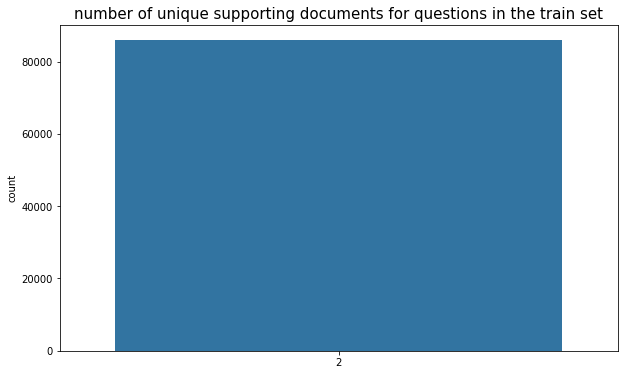

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datasets import Dataset
fig, axs = plt.subplots(1,1,figsize = (10,6))
sns.countplot(x = [len(np.unique(x['title'])) for x in hpqa['train']['supporting_facts']])
axs.set_title("number of unique supporting documents for questions in the train set", size = 15)
plt.show()


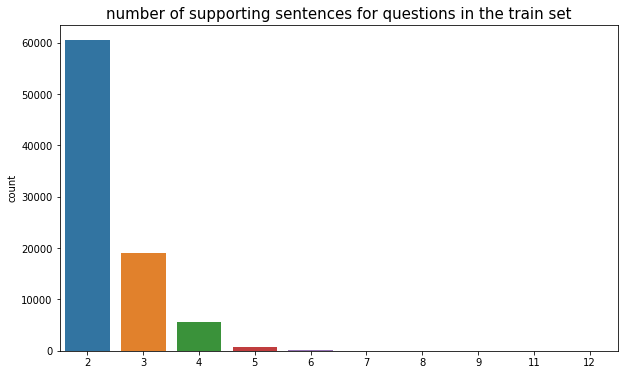

min number of supporting sentences:  2 
max number of supporting sentences:  12


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(1,1,figsize = (10,6))
num_of_sup_sent = [len(x['sent_id']) for x in hpqa['train']['supporting_facts']]
sns.countplot(x = num_of_sup_sent)
axs.set_title("number of supporting sentences for questions in the train set", size = 15)
plt.show()
print("min number of supporting sentences: ", min(num_of_sup_sent), "\nmax number of supporting sentences: ", max(num_of_sup_sent))

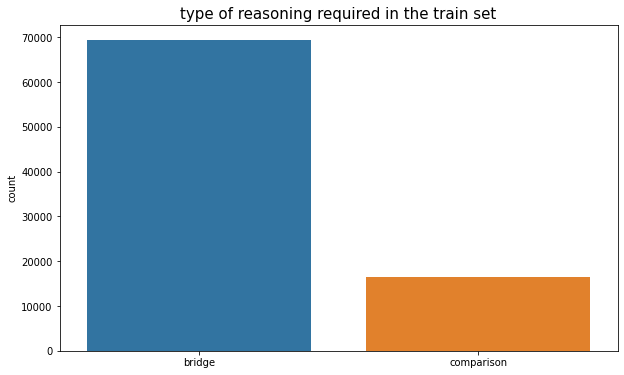

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(1,1,figsize = (10,6))
sns.countplot(x = hpqa['train']['type'])
axs.set_title("type of reasoning required in the train set", size = 15)
plt.show()

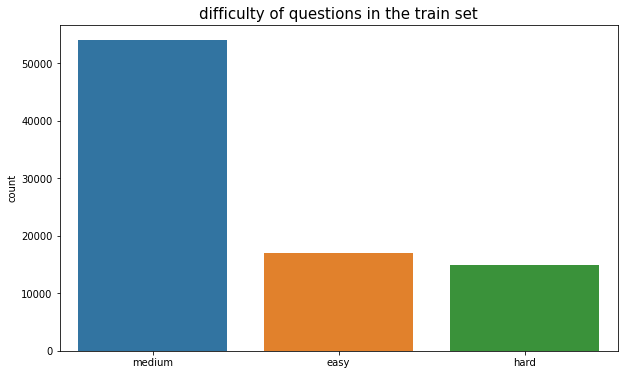

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(1,1,figsize = (10,6))
sns.countplot(x = hpqa['train']['level'])
axs.set_title("difficulty of questions in the train set", size = 15)
plt.show()


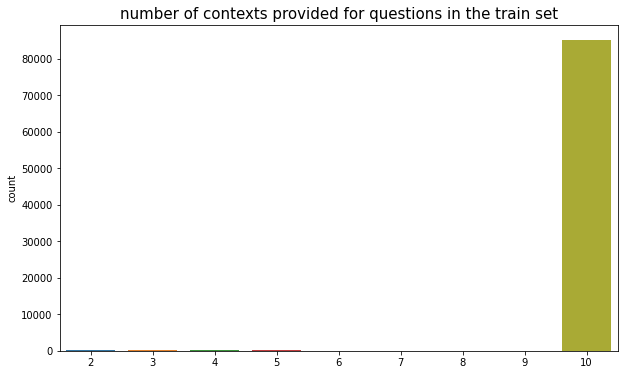

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(1,1,figsize = (10,6))
sns.countplot(x = [len(x['sentences'])for x in hpqa['train']['context']])
axs.set_title("number of contexts provided for questions in the train set", size = 15)
plt.show()


## Import Tokenizer and Model:

As the number of irrelevant provided documents is on average 4 times the number of relevant provided documents for answering a question, we are encountered with an unbalanced data classification. One way to solve this problem is to compensate the model 4 times more if it misclassifies a relevant document as irrelevant. 

In [ ]:
#weights for positive examples and negative examples
positive_weight = 0.8
negative_weight = 0.2

We choose a pretrained small-bert to finetune the task on. We previously finetuned tiny-bert and mini-bert on our data and small-bert yeilded better performance. We also finetuned bert-cased and distilRoberta and a distilRoberta finetuned on SQUAD, but small-bert had a comparable performance and faster to train.

In [ ]:
from transformers import AutoTokenizer
model_checkpoint = "prajjwal1/bert-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)

Some weights of the model checkpoint at prajjwal1/bert-small were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initi

In the following we test our small-bert tokenizer which concatenates a question and a document with a maximum length of 512 with right padding and truncates the doucment if the number of tokens exceed the maximum length. 

In [ ]:
hpqa['train'][0]['context']['sentences'][0]

['Pancho & Lefty is a honky tonk album by outlaw country musicians Merle Haggard and Willie Nelson, released in 1983.',
 ' Original vinyl copies from 1983 give the album\'s title as "Poncho & Lefty" on the cover, as well as on the inner sleeve and the record label; the album\'s title track is similarly rendered "Poncho & Lefty" on the cover, inner sleeve, and label.',
 ' Later editions correct the title to the intended "Pancho & Lefty".']

The small-bert tokenizer outputs ids of tokens in the input, their type, and the attention_mask to ignore padding. 

In [ ]:
tokenizer(hpqa['train']['question'][0], ''.join(hpqa['train'][0]['context']['sentences'][0]), padding="max_length", max_length = 512, truncation = "only_second")

{'input_ids': [101, 2041, 1997, 2192, 2003, 1037, 3339, 10189, 4801, 10228, 2243, 2201, 1010, 2011, 2029, 2406, 5455, 1998, 6009, 2124, 2005, 2010, 8200, 6819, 10024, 3406, 2376, 1998, 2010, 2670, 2600, 5105, 1010, 19104, 2406, 2614, 1029, 102, 6090, 9905, 1004, 2187, 2100, 2003, 1037, 10189, 4801, 10228, 2243, 2201, 2011, 19104, 2406, 5389, 21442, 2571, 27912, 1998, 9893, 5912, 1010, 2207, 1999, 3172, 1012, 2434, 8877, 4809, 2013, 3172, 2507, 1996, 2201, 1005, 1055, 2516, 2004, 1000, 13433, 12680, 2080, 1004, 2187, 2100, 1000, 2006, 1996, 3104, 1010, 2004, 2092, 2004, 2006, 1996, 5110, 10353, 1998, 1996, 2501, 3830, 1025, 1996, 2201, 1005, 1055, 2516, 2650, 2003, 6660, 10155, 1000, 13433, 12680, 2080, 1004, 2187, 2100, 1000, 2006, 1996, 3104, 1010, 5110, 10353, 1010, 1998, 3830, 1012, 2101, 6572, 6149, 1996, 2516, 2000, 1996, 3832, 1000, 6090, 9905, 1004, 2187, 2100, 1000, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## Preprocessing Data:

The preprocessing function splits the data into question and document pairs. By doing so the model can learn if they are relevant or irrelevant. 

In [ ]:
def prepare_train_features(examples):
  final = {'input_ids':[], 'attention_mask':[], 'labels':[], 'token_type_ids':[]}
  for i in range(len(examples['id'])):
    for j in range(len(examples['context'][i]['sentences'])):
      tokenized = tokenizer(examples['question'][i], ''.join(examples['context'][i]['sentences'][j]), padding="max_length", max_length=512, truncation='only_second')
      if examples['context'][i]['title'][j] in examples['supporting_facts'][i]['title']:
        tokenized['labels'] = 1
      else:
        tokenized['labels'] = 0
      for key in tokenized.keys():
        final[key].append(tokenized[key])
  return final

In [ ]:
par_class_dataset = hpqa.map(prepare_train_features, batched= True,remove_columns=hpqa["train"].column_names)
par_class_dataset.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"],
)

  0%|          | 0/86 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, element

In [ ]:
model.num_parameters()

28764674

## Train:

In [ ]:
from huggingface_hub import notebook_login
notebook_login()
# from huggingface_hub import create_repo, delete_repo, HfApi
# repo_name = f"nlpproject2023/small-bert"

# # creating the repository in the hub 
# create_repo(repo_name, repo_type='model', private= False)

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


We trained the model with floating point 16 precision to be able to fit the training on GPU. The batchsize for training is 64. We trained the model for 3 epochs. 

In [ ]:
from transformers import Trainer, TrainingArguments
import numpy as np
device = 'cuda'
training_args = TrainingArguments(
    output_dir = "nlpproject2023/small-bert",
    fp16 = True,
    per_device_train_batch_size = 64,
    per_device_eval_batch_size=128,
    evaluation_strategy = 'steps',
    logging_steps = 4000,
    save_steps = 8000,
    push_to_hub = True,
    hub_strategy = 'checkpoint',
    overwrite_output_dir = True,
    resume_from_checkpoint = 'last-checkpoint',
    load_best_model_at_end = True
)

We modify the trainer to implement our custom weighted loss function:

In [ ]:
import torch
from torch import nn
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs = False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([negative_weight,positive_weight]).to(device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [ ]:
from datasets import load_metric
metric = load_metric('accuracy')
def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis = 1)
  return metric.compute(predictions= predictions, references = labels)

<ipython-input-21-873c049532c6>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('accuracy')


In [ ]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=par_class_dataset['train'],
    eval_dataset = par_class_dataset['validation'],
    compute_metrics = compute_metrics
)
trainer.train(resume_from_checkpoint = 'nlpproject2023/small-bert/last-checkpoint')

Cloning https://huggingface.co/nlpproject2023/medium-bert into local empty directory.


Download file last-checkpoint/optimizer.pt:   0%|          | 32.0k/219M [00:00<?, ?B/s]

Download file last-checkpoint/rng_state.pth: 100%|##########| 14.2k/14.2k [00:00<?, ?B/s]

Download file last-checkpoint/pytorch_model.bin:   0%|          | 32.0k/110M [00:00<?, ?B/s]

Download file runs/Jan26_20-34-29_0be793c1604d/1674765373.7908413/events.out.tfevents.1674765373.0be793c1604d.…

Download file runs/Jan25_14-00-32_39f7c40b5b0d/events.out.tfevents.1674655250.39f7c40b5b0d.266.0: 100%|#######…

Download file runs/Jan26_10-20-25_4237fc6e1de3/1674729726.4755096/events.out.tfevents.1674729726.4237fc6e1de3.…

Download file runs/Jan26_20-37-20_0be793c1604d/1674765708.6072876/events.out.tfevents.1674765708.0be793c1604d.…

Download file runs/Jan26_20-37-20_0be793c1604d/events.out.tfevents.1674765708.0be793c1604d.802.2: 100%|#######…

Clean file last-checkpoint/rng_state.pth:   7%|7         | 1.00k/14.2k [00:00<?, ?B/s]

Clean file runs/Jan26_20-34-29_0be793c1604d/1674765373.7908413/events.out.tfevents.1674765373.0be793c1604d.802…

Download file runs/Jan25_14-00-32_39f7c40b5b0d/1674655250.8479736/events.out.tfevents.1674655250.39f7c40b5b0d.…

Download file runs/Jan26_20-34-29_0be793c1604d/events.out.tfevents.1674765373.0be793c1604d.802.0: 100%|#######…

Clean file runs/Jan25_14-00-32_39f7c40b5b0d/events.out.tfevents.1674655250.39f7c40b5b0d.266.0:  15%|#5        …

Download file runs/Jan26_13-10-18_91cef95ce564/events.out.tfevents.1674738625.91cef95ce564.3921.0: 100%|######…

Clean file runs/Jan26_10-20-25_4237fc6e1de3/1674729726.4755096/events.out.tfevents.1674729726.4237fc6e1de3.251…

Download file runs/Jan26_10-20-25_4237fc6e1de3/events.out.tfevents.1674729726.4237fc6e1de3.251.2: 100%|#######…

Clean file runs/Jan26_20-37-20_0be793c1604d/1674765708.6072876/events.out.tfevents.1674765708.0be793c1604d.802…

Clean file runs/Jan26_20-37-20_0be793c1604d/events.out.tfevents.1674765708.0be793c1604d.802.2:  17%|#7        …

Download file runs/Jan26_10-20-25_4237fc6e1de3/1674728466.2703867/events.out.tfevents.1674728466.4237fc6e1de3.…

Download file runs/Jan26_10-20-25_4237fc6e1de3/events.out.tfevents.1674728466.4237fc6e1de3.251.0: 100%|#######…

Download file last-checkpoint/training_args.bin: 100%|##########| 3.43k/3.43k [00:00<?, ?B/s]

Download file last-checkpoint/scaler.pt: 100%|##########| 557/557 [00:00<?, ?B/s]

Clean file runs/Jan25_14-00-32_39f7c40b5b0d/1674655250.8479736/events.out.tfevents.1674655250.39f7c40b5b0d.266…

Clean file runs/Jan26_20-34-29_0be793c1604d/events.out.tfevents.1674765373.0be793c1604d.802.0:  26%|##6       …

Download file runs/Jan26_13-10-18_91cef95ce564/1674738625.3207452/events.out.tfevents.1674738625.91cef95ce564.…

Clean file runs/Jan26_13-10-18_91cef95ce564/events.out.tfevents.1674738625.91cef95ce564.3921.0:  18%|#8       …

Clean file runs/Jan26_10-20-25_4237fc6e1de3/events.out.tfevents.1674729726.4237fc6e1de3.251.2:  21%|##1       …

Download file last-checkpoint/scheduler.pt: 100%|##########| 627/627 [00:00<?, ?B/s]

Clean file runs/Jan26_10-20-25_4237fc6e1de3/1674728466.2703867/events.out.tfevents.1674728466.4237fc6e1de3.251…

Clean file last-checkpoint/training_args.bin:  29%|##9       | 1.00k/3.43k [00:00<?, ?B/s]

Clean file training_args.bin:  29%|##9       | 1.00k/3.43k [00:00<?, ?B/s]

Clean file runs/Jan26_10-20-25_4237fc6e1de3/events.out.tfevents.1674728466.4237fc6e1de3.251.0:  26%|##6       …

Clean file last-checkpoint/scaler.pt: 100%|##########| 557/557 [00:00<?, ?B/s]

Clean file runs/Jan26_13-10-18_91cef95ce564/1674738625.3207452/events.out.tfevents.1674738625.91cef95ce564.392…

Clean file last-checkpoint/scheduler.pt: 100%|##########| 627/627 [00:00<?, ?B/s]

Clean file last-checkpoint/pytorch_model.bin:   0%|          | 1.00k/110M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/110M [00:00<?, ?B/s]

Clean file last-checkpoint/optimizer.pt:   0%|          | 1.00k/219M [00:00<?, ?B/s]

Using cuda_amp half precision backend
Loading model from nlpproject2023/medium-bert/last-checkpoint.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 854651
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 40062
  Number of trainable parameters = 28764674
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 2
  Continuing training from global step 32000
  Will skip the first 2 epochs then the first 5292 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip

  0%|          | 0/5292 [00:00<?, ?it/s]

Step,Training Loss,Validation Loss,Accuracy
36000,0.099200,0.174077,0.951795
40000,0.093100,0.177202,0.952928


***** Running Evaluation *****
  Num examples = 45016
  Batch size = 128
***** Running Evaluation *****
  Num examples = 45016
  Batch size = 128
Saving model checkpoint to nlpproject2023/medium-bert/checkpoint-40000
Configuration saved in nlpproject2023/medium-bert/checkpoint-40000/config.json
Model weights saved in nlpproject2023/medium-bert/checkpoint-40000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from nlpproject2023/medium-bert/checkpoint-24000 (score: 0.17474637925624847).
Could not locate the best model at nlpproject2023/medium-bert/checkpoint-24000/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


ValueError: ignored

## Post Processing:

PostProcessing part is to convert the output of the model to a well-formated Dataset to pass it to the next module. 

In [ ]:
from transformers import AutoModelForSequenceClassification
model_checkpoint = 'nlpproject2023/small-bert'
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)
model.eval()
device = "cuda"

The script for post processing the output of our model. For each sample in the original dataset (each question), we predict it's relevant doucment. 
In the final post processed output at each row we have a question from the test dataset, the predicted relevant documents and the correspondant sentences inside them. 

In [ ]:
import pandas as pd
from datasets import Dataset
from tqdm import tqdm
output_test = Dataset.from_pandas(pd.DataFrame(columns = ['id', 'question', 'context']), preserve_index=False)
with torch.no_grad():
  model.to(device)
  for i in tqdm(range(len(hpqa['test']))):
    row = {}
    batch = Dataset.from_dict(prepare_train_features(hpqa['test'][i:i+1]))
    batch.set_format(type='torch', columns=["input_ids", "attention_mask", "labels", "token_type_ids"])
    title = []
    sentences = []
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    token_type_ids = batch["token_type_ids"].to(device)
    preds = torch.argmax(model(input_ids = input_ids, attention_mask = attention_mask, labels = labels, token_type_ids = token_type_ids).logits, axis = 1)
    for j , pred in enumerate(preds):
      if pred == 1:
        title.append(hpqa['test'][i]['context']['title'][j])
        sentences.append(hpqa['test'][i]['context']['sentences'][j])
    row['id'] = hpqa['test'][i]['id']
    row['question'] = hpqa['test'][i]['question']
    row['context'] = {'title':title, 'sentences': sentences}
    output_test = output_test.add_item(row)

100%|██████████| 7405/7405 [15:10<00:00,  8.13it/s]


In [ ]:
import pandas as pd
from datasets import Dataset
from tqdm import tqdm
output_val = Dataset.from_pandas(pd.DataFrame(columns = ['id', 'question', 'context']), preserve_index=False)
with torch.no_grad():
  model.to(device)
  for i in tqdm(range(len(hpqa['validation']))):
    row = {}
    batch = Dataset.from_dict(prepare_train_features(hpqa['validation'][i:i+1]))
    batch.set_format(type='torch', columns=["input_ids", "attention_mask", "labels", "token_type_ids"])
    title = []
    sentences = []
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    token_type_ids = batch["token_type_ids"].to(device)
    preds = torch.argmax(model(input_ids = input_ids, attention_mask = attention_mask, labels = labels, token_type_ids = token_type_ids).logits, axis = 1)
    for j , pred in enumerate(preds):
      if pred == 1:
        title.append(hpqa['validation'][i]['context']['title'][j])
        sentences.append(hpqa['validation'][i]['context']['sentences'][j])
    row['id'] = hpqa['validation'][i]['id']
    row['question'] = hpqa['validation'][i]['question']
    row['context'] = {'title':title, 'sentences': sentences}
    output_val = output_val.add_item(row)

100%|██████████| 4523/4523 [07:05<00:00, 10.62it/s]


In [ ]:
from datasets import DatasetDict
output = DatasetDict()
output['validation'] = output_val
output['test'] = output_test

In [ ]:
output

DatasetDict({
    validation: Dataset({
        features: ['id', 'question', 'context'],
        num_rows: 4523
    })
    test: Dataset({
        features: ['id', 'question', 'context'],
        num_rows: 7405
    })
})

In [ ]:
output.push_to_hub("nlpproject2023/Paragraphs")

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

## Evaluation:

In [ ]:
from datasets import load_dataset
output =load_dataset("nlpproject2023/Paragraphs")
output

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/7405 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4523 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/nlpproject2023___parquet/nlpproject2023--Paragraphs-800dad5c02f48283/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    test: Dataset({
        features: ['id', 'question', 'context'],
        num_rows: 7405
    })
    validation: Dataset({
        features: ['id', 'question', 'context'],
        num_rows: 4523
    })
})

Examples of comparison between what the model predicts as relevant documents vs the gold relevant documents

In [ ]:
from pprint import pprint
for i in range(10):
  print("\n \n prediction: ")
  pprint(output['test'][i])

  print("\n \ngold:")
  pprint(hpqa['test'][i])


 
 prediction: 
{'context': {'sentences': [['Scott Derrickson (born July 16, 1966) is an '
                            'American director, screenwriter and producer.',
                            ' He lives in Los Angeles, California.',
                            ' He is best known for directing horror films such '
                            'as "Sinister", "The Exorcism of Emily Rose", and '
                            '"Deliver Us From Evil", as well as the 2016 '
                            'Marvel Cinematic Universe installment, "Doctor '
                            'Strange."'],
                           ['Edward Davis Wood Jr. (October 10, 1924 – '
                            'December 10, 1978) was an American filmmaker, '
                            'actor, writer, producer, and director.']],
             'title': ['Scott Derrickson', 'Ed Wood']},
 'id': '5a8b57f25542995d1e6f1371',
 'question': 'Were Scott Derrickson and Ed Wood of the same nationality?'}

 
gold:
{'answer'

#### Validation:

To evaluate F1 and Exact Match scores we compare the post processed output of the model for the validation set and compare it to the groundtruth.

In [ ]:
from datasets import load_metric
from tqdm import tqdm
f1 = load_metric("f1")
f1_scores = []
em_scores = []
for i in tqdm(range(len(hpqa['validation']))):
  gold = hpqa['validation'][i]['supporting_facts']['title']
  pred = output['validation'][i]['context']['title']
  gold_classes = [1 if (x in gold) else 0 for x in hpqa['validation'][i]['context']['title']]
  pred_classes = [1 if (x in pred) else 0 for x in hpqa['validation'][i]['context']['title']]
  em_scores.append(gold_classes == pred_classes)
  f1_scores.append(f1.compute(predictions = pred_classes, references = gold_classes)['f1'])



  0%|          | 0/4523 [00:00<?, ?it/s]

  1%|          | 23/4523 [00:00<00:20, 223.28it/s]

  1%|          | 46/4523 [00:00<00:20, 219.45it/s]

  2%|▏         | 68/4523 [00:00<00:20, 217.89it/s]

  2%|▏         | 90/4523 [00:00<00:21, 201.68it/s]

  2%|▏         | 111/4523 [00:00<00:21, 202.46it/s]

  3%|▎         | 133/4523 [00:00<00:21, 207.35it/s]

  3%|▎         | 154/4523 [00:00<00:21, 205.23it/s]

  4%|▍         | 175/4523 [00:00<00:21, 204.59it/s]

  4%|▍         | 197/4523 [00:00<00:20, 208.43it/s]

  5%|▍         | 220/4523 [00:01<00:20, 212.31it/s]

  5%|▌         | 242/4523 [00:01<00:19, 214.13it/s]

  6%|▌         | 264/4523 [00:01<00:20, 210.58it/s]

  6%|▋         | 287/4523 [00:01<00:19, 214.13it/s]

  7%|▋         | 309/4523 [00:01<00:20, 207.99it/s]

  7%|▋         | 332/4523 [00:01<00:19, 212.99it/s]

  8%|▊         | 355/4523 [00:01<00:19, 214.30it/s]

  8%|▊         | 377/4523 [00:01<00:24, 172.23it/s]

  9%|▉         | 396/4523 [00:02<00:25, 163.85it/s]

  9%|▉

In [ ]:
print(f"f1_score: {np.round(np.mean(f1_scores),4)}")
print(f"exact_match_score: {np.round(np.mean(em_scores),4)}")

f1_score: 0.8972
exact_match_score: 0.6841


In [ ]:
f1_scores_bridge = np.array(f1_scores)[np.array(hpqa['validation']['type']) == 'bridge']
em_scores_bridge = np.array(em_scores)[np.array(hpqa['validation']['type']) == 'bridge']
f1_scores_comparison = np.array(f1_scores)[np.array(hpqa['validation']['type']) == 'comparison']
em_scores_comparison = np.array(em_scores)[np.array(hpqa['validation']['type']) == 'comparison']
print(f"F1/EM score on questions of type bridge: {np.round(np.mean(f1_scores_bridge),4)}/{np.round(np.mean(em_scores_bridge),4)} ")
print(f"F1/EM score on questions of type comparison: {np.round(np.mean(f1_scores_comparison),4)}/{np.round(np.mean(em_scores_comparison),4)}")

F1/EM score on questions of type bridge: 0.8776/0.6284 
F1/EM score on questions of type comparison: 0.9777/0.9121


In [ ]:
f1_scores_easy = np.array(f1_scores)[np.array(hpqa['validation']['level']) == 'easy']
em_scores_easy = np.array(em_scores)[np.array(hpqa['validation']['level']) == 'easy']
f1_scores_medium = np.array(f1_scores)[np.array(hpqa['validation']['level']) == 'medium']
em_scores_medium = np.array(em_scores)[np.array(hpqa['validation']['level']) == 'medium']
f1_scores_hard = np.array(f1_scores)[np.array(hpqa['validation']['level']) == 'hard']
em_scores_hard = np.array(em_scores)[np.array(hpqa['validation']['level']) == 'hard']
print(f"F1/EM score on easy questions: {np.round(np.mean(f1_scores_easy),4)}/{np.round(np.mean(em_scores_easy),4)} ")
print(f"F1/EM score on medium questions: {np.round(np.mean(f1_scores_medium),4)}/{np.round(np.mean(em_scores_medium),4)}")
print(f"F1/EM score on hard questions: {np.round(np.mean(f1_scores_hard),4)}/{np.round(np.mean(em_scores_hard),4)} ")

F1/EM score on easy questions: 0.9202/0.7503 
F1/EM score on medium questions: 0.8949/0.6741
F1/EM score on hard questions: 0.8795/0.6452 


#### Test:

To evaluate F1 and Exact Match scores we compare the post processed output of the model for the test set and compare it to the groundtruth.

In [ ]:
from datasets import load_metric
from tqdm import tqdm
f1 = load_metric("f1")
f1_scores = []
em_scores = []
for i in tqdm(range(len(hpqa['test']))):
  gold = hpqa['test'][i]['supporting_facts']['title']
  pred = output['test'][i]['context']['title']
  gold_classes = [1 if (x in gold) else 0 for x in hpqa['test'][i]['context']['title']]
  pred_classes = [1 if (x in pred) else 0 for x in hpqa['test'][i]['context']['title']]
  em_scores.append(gold_classes == pred_classes)
  f1_scores.append(f1.compute(predictions = pred_classes, references = gold_classes)['f1'])



  0%|          | 0/7405 [00:00<?, ?it/s]

  0%|          | 14/7405 [00:00<01:02, 117.74it/s]

  0%|          | 27/7405 [00:00<01:00, 122.02it/s]

  1%|          | 40/7405 [00:00<01:06, 111.38it/s]

  1%|          | 61/7405 [00:00<00:50, 144.92it/s]

  1%|          | 83/7405 [00:00<00:43, 166.52it/s]

  1%|▏         | 100/7405 [00:00<00:49, 146.92it/s]

  2%|▏         | 116/7405 [00:00<00:52, 138.59it/s]

  2%|▏         | 131/7405 [00:00<00:54, 134.17it/s]

  2%|▏         | 145/7405 [00:01<00:59, 121.52it/s]

  2%|▏         | 158/7405 [00:01<01:02, 116.04it/s]

  2%|▏         | 173/7405 [00:01<00:58, 124.35it/s]

  3%|▎         | 186/7405 [00:01<00:58, 122.76it/s]

  3%|▎         | 199/7405 [00:01<00:58, 122.99it/s]

  3%|▎         | 212/7405 [00:01<00:59, 120.15it/s]

  3%|▎         | 225/7405 [00:01<00:59, 120.69it/s]

  3%|▎         | 238/7405 [00:01<01:08, 104.36it/s]

  3%|▎         | 250/7405 [00:02<01:06, 108.26it/s]

  4%|▎         | 262/7405 [00:02<01:06, 108.05it/s]

  4%|▎ 

In [ ]:
print(f"f1_score: {np.round(np.mean(f1_scores),4)}")
print(f"exact_match_score: {np.round(np.mean(em_scores),4)}")

f1_score: 0.884
exact_match_score: 0.6548


In [ ]:
f1_scores_bridge = np.array(f1_scores)[np.array(hpqa['test']['type']) == 'bridge']
em_scores_bridge = np.array(em_scores)[np.array(hpqa['test']['type']) == 'bridge']
f1_scores_comparison = np.array(f1_scores)[np.array(hpqa['test']['type']) == 'comparison']
em_scores_comparison = np.array(em_scores)[np.array(hpqa['test']['type']) == 'comparison']
print(f"F1/EM score on questions of type bridge: {np.round(np.mean(f1_scores_bridge),4)}/{np.round(np.mean(em_scores_bridge),4)} ")
print(f"F1/EM score on questions of type comparison: {np.round(np.mean(f1_scores_comparison),4)}/{np.round(np.mean(em_scores_comparison),4)}")

F1/EM score on questions of type bridge: 0.8605/0.5906 
F1/EM score on questions of type comparison: 0.9775/0.9106
